## Property Price Register

### Exploratory Spatial Data Analysis

In this notebook we introduce methods of exploratory spatial data analysis that are intended to complement geovizualization through formal univariate and multivariate statistical tests for spatial clustering.



In [36]:
# import libraries
import pandas as pd
import esda
import seaborn as sns
import matplotlib.pyplot as plt
import libpysal as lp
import shapely.geometry as geom
from shapely.geometry import Point
import numpy as np

In [2]:
df = pd.read_csv('tidyppr.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408319 entries, 0 to 408318
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 408319 non-null  int64  
 1   year                       408319 non-null  int64  
 2   Date                       408319 non-null  object 
 3   Postal Code                77725 non-null   object 
 4   County                     408319 non-null  object 
 5   Price                      408319 non-null  float64
 6   Not Full Market Price      408319 non-null  object 
 7   VAT Exclusive              408319 non-null  object 
 8   Description of Property    408319 non-null  object 
 9   Property Size Description  45140 non-null   object 
 10  formatted_address          393884 non-null  object 
 11  accuracy                   393888 non-null  object 
 12  latitude                   393888 non-null  float64
 13  longitude                  39

### Convert Data Types

In [4]:
from datetime import datetime

In [5]:
df['Date'] =  pd.to_datetime(df['Date'])

In [6]:
df["Price"] = df['Price'].astype('int64')

In [7]:
df = df.replace({'VAT Exclusive': {'Yes': True, 'No': False}})

In [8]:
df = df.replace({'Not Full Market Price': {'Yes': True, 'No': False}})

In [9]:
df["VAT Exclusive"] = df['VAT Exclusive'].astype('boolean')

In [10]:
df["Not Full Market Price"] = df['Not Full Market Price'].astype('boolean')

1. Based on the information above we can see that 393,888 addresses were geocoded out of a possible 408,319.
2. We can also see that some of the coloumns are missing a lot of values.
2. Below we will remove any columns with more than 40% missing values.

In [11]:
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.4]]
del df2['Unnamed: 0']
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
df = df2


List of dropped columns: Unnamed: 0, Postal Code, Property Size Description, 



As we can see from above the columns Unnamed: 0, Postal Code and Property Size Description have been dropped. The reason for this is because data is entered into the Property Price Register manually and does not force the user to complete all fields.

### Cleaning data
1. If a property is VAT Exclusive then the property is new which means we can drop the Description of the property column.
2. As our data is geocoded we no longer need the postcodes so we will also drop it.
3. Accuracy is google response to ensure our data is geocoded correctly at this point we no longer need it so we will drop that too.

In [12]:
df = df.drop(['Description of Property','postcode','accuracy','type'], axis=1)
df

,year,Date,County,Price,Not Full Market Price,VAT Exclusive,formatted_address,latitude,longitude
0,2012,2012-09-18,Cork,118000,False,False,"Saint Martins, Kilbeg, Ightermurragh, Ladysbri...",51.898721,-8.027057
1,2012,2012-01-16,Tipperary,210000,False,False,"The Stone House, Ballyglass Upper, Co. Tippera...",52.438674,-8.171166
2,2012,2012-01-23,Kildare,220000,False,False,"Avondale, Morristown Rd, Moorfield, Newbridge,...",53.178275,-6.815277
3,2012,2012-12-12,Dublin,496089,False,False,"61 Dublin Rd, Miltonsfields, Swords, Co. Dubli...",53.451025,-6.225203
4,2012,2012-01-25,Cork,240000,False,False,"33 Glasheen Rd, Liam Lynch Park, Glasheen, Cor...",51.884846,-8.505120
...,...,...,...,...,...,...,...,...,...
408314,2020,2020-05-22,Tipperary,70000,False,False,"2 Main St, Townparks, Roscrea, Co. Tipperary, ...",52.956481,-7.799102
408315,2020,2020-05-22,Limerick,250000,False,False,"Cloonoughter, Co. Limerick, Ireland",52.568506,-9.246203
408316,2020,2020-05-22,Cork,500000,False,False,"Highgrove, Johnstown, Annmount, Co. Cork, Ireland",51.912757,-8.331703
408317,2020,2020-05-22,Meath,99000,False,False,"Ballinlough, Lough Bawn, Co. Meath, Ireland",53.693480,-7.173900


### Geopandas

Now we will use geopandas to map our small area shape file with our PPR data.

In [13]:
import geopandas

In [14]:
from shapely.geometry import Point, Polygon

In [15]:
small_areas = geopandas.read_file('irl.shp')

In [16]:
small_areas

,OBJECTID,GUID,NUTS1,NUTS1NAME,NUTS2,NUTS2NAME,NUTS3,NUTS3NAME,COUNTY,COUNTYNAME,...,ESRI_OID,Shape__Are,Shape__Len,TotalPop,Housing St,Occupied,Unoccupied,Temporaril,VacantPerc,geometry
0,1,4c07d11d-f71d-851d-e053-ca3ca8c0ca7f,IE,Ireland,IE05,Southern,IE053,South-West,CK,Cork County,...,1,2.436209e+07,25179.376645,154,75,61,2.0,2.0,6.3,"POLYGON ((-9.09329 51.79897, -9.09309 51.79897..."
1,2,4c07d11d-f71e-851d-e053-ca3ca8c0ca7f,IE,Ireland,IE05,Southern,IE053,South-West,CK,Cork County,...,2,1.215051e+07,23595.409065,283,108,94,2.0,5.0,18.5,"POLYGON ((-8.98764 51.72759, -8.98742 51.72763..."
2,3,4c07d11d-f71f-851d-e053-ca3ca8c0ca7f,IE,Ireland,IE05,Southern,IE053,South-West,CK,Cork County,...,3,9.331929e+06,18078.254302,228,92,73,1.0,1.0,16.5,"POLYGON ((-8.93013 51.72561, -8.93007 51.72566..."
3,4,4c07d11d-f720-851d-e053-ca3ca8c0ca7f,IE,Ireland,IE05,Southern,IE053,South-West,CK,Cork County,...,4,1.134573e+07,22123.902506,180,118,78,20.0,1.0,2.1,"POLYGON ((-8.92680 51.73688, -8.92685 51.73711..."
4,5,4c07d11d-f564-851d-e053-ca3ca8c0ca7f,IE,Ireland,IE04,Northern and Western,IE042,West,GY,Galway County,...,5,8.135992e+07,71992.829074,194,121,68,27.0,3.0,9.1,"POLYGON ((-9.54482 53.42068, -9.54485 53.42069..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18636,18637,4c07d11e-3b99-851d-e053-ca3ca8c0ca7f,IE,Ireland,IE06,Eastern and Midland,IE061,Dublin,DR,DÃºn Laoghaire-Rathdown,...,18637,1.493571e+04,497.940601,349,97,97,NaN,NaN,3.9,"POLYGON ((-6.14090 53.26959, -6.14095 53.26953..."
18637,18638,4c07d11e-3b9a-851d-e053-ca3ca8c0ca7f,IE,Ireland,IE06,Eastern and Midland,IE061,Dublin,DR,DÃºn Laoghaire-Rathdown,...,18638,1.004670e+04,462.357975,148,107,75,NaN,7.0,6.1,"POLYGON ((-6.24302 53.27999, -6.24303 53.28028..."
18638,18639,4c07d11e-3b9b-851d-e053-ca3ca8c0ca7f,IE,Ireland,IE06,Eastern and Midland,IE061,Dublin,DR,DÃºn Laoghaire-Rathdown,...,18639,1.301185e+04,492.908907,134,85,77,NaN,1.0,3.5,"POLYGON ((-6.21417 53.27828, -6.21514 53.27721..."
18639,18640,4c07d11e-3baa-851d-e053-ca3ca8c0ca7f,IE,Ireland,IE06,Eastern and Midland,IE061,Dublin,FL,Fingal,...,18640,2.280690e+04,625.759061,138,77,57,NaN,8.0,10.4,"POLYGON ((-6.20373 53.61362, -6.20370 53.61351..."


In [17]:
small_areas = small_areas[['OBJECTID', 'geometry']]

In [18]:
# Converting dataframe to geodataframe
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))
gdf

,year,Date,County,Price,Not Full Market Price,VAT Exclusive,formatted_address,latitude,longitude,geometry
0,2012,2012-09-18,Cork,118000,False,False,"Saint Martins, Kilbeg, Ightermurragh, Ladysbri...",51.898721,-8.027057,POINT (-8.02706 51.89872)
1,2012,2012-01-16,Tipperary,210000,False,False,"The Stone House, Ballyglass Upper, Co. Tippera...",52.438674,-8.171166,POINT (-8.17117 52.43867)
2,2012,2012-01-23,Kildare,220000,False,False,"Avondale, Morristown Rd, Moorfield, Newbridge,...",53.178275,-6.815277,POINT (-6.81528 53.17828)
3,2012,2012-12-12,Dublin,496089,False,False,"61 Dublin Rd, Miltonsfields, Swords, Co. Dubli...",53.451025,-6.225203,POINT (-6.22520 53.45102)
4,2012,2012-01-25,Cork,240000,False,False,"33 Glasheen Rd, Liam Lynch Park, Glasheen, Cor...",51.884846,-8.505120,POINT (-8.50512 51.88485)
...,...,...,...,...,...,...,...,...,...,...
408314,2020,2020-05-22,Tipperary,70000,False,False,"2 Main St, Townparks, Roscrea, Co. Tipperary, ...",52.956481,-7.799102,POINT (-7.79910 52.95648)
408315,2020,2020-05-22,Limerick,250000,False,False,"Cloonoughter, Co. Limerick, Ireland",52.568506,-9.246203,POINT (-9.24620 52.56851)
408316,2020,2020-05-22,Cork,500000,False,False,"Highgrove, Johnstown, Annmount, Co. Cork, Ireland",51.912757,-8.331703,POINT (-8.33170 51.91276)
408317,2020,2020-05-22,Meath,99000,False,False,"Ballinlough, Lough Bawn, Co. Meath, Ireland",53.693480,-7.173900,POINT (-7.17390 53.69348)


In [19]:
# Now we have created a geometric point for each address we can drop the latitude and longitude along with strings.
geo = gdf.drop(['County','year','formatted_address'], axis=1)

## Coordinate Reference System

In [20]:
geo.crs = {'init' :'epsg:4326'}

In [21]:
geo.crs

{'init': 'epsg:4326'}

In [22]:
small_areas.crs

{'init': 'epsg:4326'}

In [23]:
geo

,Date,Price,Not Full Market Price,VAT Exclusive,latitude,longitude,geometry
0,2012-09-18,118000,False,False,51.898721,-8.027057,POINT (-8.02706 51.89872)
1,2012-01-16,210000,False,False,52.438674,-8.171166,POINT (-8.17117 52.43867)
2,2012-01-23,220000,False,False,53.178275,-6.815277,POINT (-6.81528 53.17828)
3,2012-12-12,496089,False,False,53.451025,-6.225203,POINT (-6.22520 53.45102)
4,2012-01-25,240000,False,False,51.884846,-8.505120,POINT (-8.50512 51.88485)
...,...,...,...,...,...,...,...
408314,2020-05-22,70000,False,False,52.956481,-7.799102,POINT (-7.79910 52.95648)
408315,2020-05-22,250000,False,False,52.568506,-9.246203,POINT (-9.24620 52.56851)
408316,2020-05-22,500000,False,False,51.912757,-8.331703,POINT (-8.33170 51.91276)
408317,2020-05-22,99000,False,False,53.693480,-7.173900,POINT (-7.17390 53.69348)


In [24]:
geo = geopandas.sjoin(geo, small_areas, how="inner", op='within')
geo

C:\Users\callm\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


,Date,Price,Not Full Market Price,VAT Exclusive,latitude,longitude,geometry,index_right,OBJECTID
0,2012-09-18,118000,False,False,51.898721,-8.027057,POINT (-8.02706 51.89872),3525,3526
19642,2012-06-07,220000,False,False,51.897608,-8.043334,POINT (-8.04333 51.89761),3525,3526
24083,2012-05-04,205000,False,False,51.897608,-8.043334,POINT (-8.04333 51.89761),3525,3526
34998,2013-05-23,220000,False,False,51.895563,-8.043080,POINT (-8.04308 51.89556),3525,3526
51394,2013-01-23,165000,False,False,51.897153,-8.042858,POINT (-8.04286 51.89715),3525,3526
...,...,...,...,...,...,...,...,...,...
406480,2020-04-24,33000,False,False,53.553614,-7.948399,POINT (-7.94840 53.55361),1911,1912
406606,2020-04-27,300000,True,False,52.945674,-7.356926,POINT (-7.35693 52.94567),4594,4595
406685,2020-04-28,37500,False,False,53.793916,-7.587912,POINT (-7.58791 53.79392),3197,3198
407684,2020-11-05,177400,False,False,53.830573,-8.765583,POINT (-8.76558 53.83057),3639,3640


In [25]:
geo.to_csv('geo-ppr.csv')

In [30]:
geo

,Date,Price,Not Full Market Price,VAT Exclusive,latitude,longitude,geometry,index_right,OBJECTID
0,2012-09-18,118000,False,False,51.898721,-8.027057,POINT (-8.02706 51.89872),3525,3526
19642,2012-06-07,220000,False,False,51.897608,-8.043334,POINT (-8.04333 51.89761),3525,3526
24083,2012-05-04,205000,False,False,51.897608,-8.043334,POINT (-8.04333 51.89761),3525,3526
34998,2013-05-23,220000,False,False,51.895563,-8.043080,POINT (-8.04308 51.89556),3525,3526
51394,2013-01-23,165000,False,False,51.897153,-8.042858,POINT (-8.04286 51.89715),3525,3526
...,...,...,...,...,...,...,...,...,...
406480,2020-04-24,33000,False,False,53.553614,-7.948399,POINT (-7.94840 53.55361),1911,1912
406606,2020-04-27,300000,True,False,52.945674,-7.356926,POINT (-7.35693 52.94567),4594,4595
406685,2020-04-28,37500,False,False,53.793916,-7.587912,POINT (-7.58791 53.79392),3197,3198
407684,2020-11-05,177400,False,False,53.830573,-8.765583,POINT (-8.76558 53.83057),3639,3640


## Save to csv

The above function took several minutes to complete so at this point we will save the results.

In [31]:
df = geo.groupby('OBJECTID').agg({'Price': ['mean', 'min', 'max','count']})
# rename columns
df.columns = ['mean', 'min', 'max','sold']

# reset index to get grouped columns back
df = df.reset_index()

print(df)

       OBJECTID           mean     min     max  sold
0             1  140810.400000   40000  310000     5
1             2  164125.000000   50000  562000     8
2             3  274571.428571   50000  447500     7
3             4  179166.666667   18000  300000    18
4             5  125000.000000  125000  125000     1
...         ...            ...     ...     ...   ...
18348     18636  241575.025000  140969  320000    40
18349     18637  287176.116279  157500  349950    43
18350     18639  294106.360000   95000  443733   175
18351     18640  159500.000000   65000  220000    20
18352     18641  192243.750000  115000  235000     8

[18353 rows x 5 columns]


In [38]:
esd = small_areas.merge(df, on='OBJECTID')
esd

,OBJECTID,geometry,mean,min,max,sold
0,1,"POLYGON ((-9.09329 51.79897, -9.09309 51.79897...",140810.400000,40000,310000,5
1,2,"POLYGON ((-8.98764 51.72759, -8.98742 51.72763...",164125.000000,50000,562000,8
2,3,"POLYGON ((-8.93013 51.72561, -8.93007 51.72566...",274571.428571,50000,447500,7
3,4,"POLYGON ((-8.92680 51.73688, -8.92685 51.73711...",179166.666667,18000,300000,18
4,5,"POLYGON ((-9.54482 53.42068, -9.54485 53.42069...",125000.000000,125000,125000,1
...,...,...,...,...,...,...
18348,18636,"POLYGON ((-6.12317 53.25084, -6.12334 53.25085...",241575.025000,140969,320000,40
18349,18637,"POLYGON ((-6.14090 53.26959, -6.14095 53.26953...",287176.116279,157500,349950,43
18350,18639,"POLYGON ((-6.21417 53.27828, -6.21514 53.27721...",294106.360000,95000,443733,175
18351,18640,"POLYGON ((-6.20373 53.61362, -6.20370 53.61351...",159500.000000,65000,220000,20


## Median House Prices Ireland Quantiles

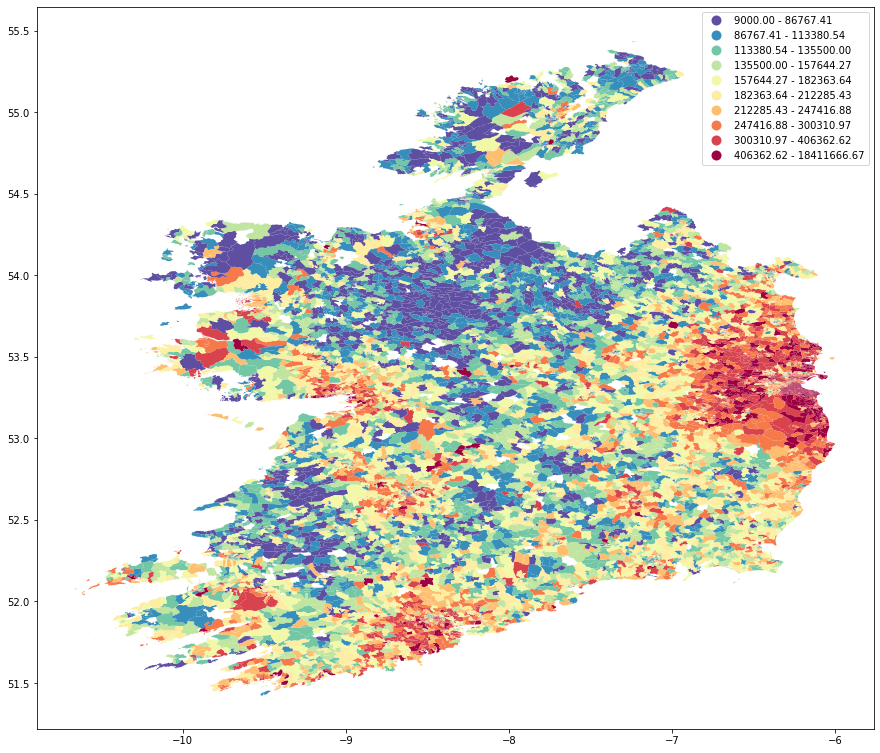

In [39]:
fig, ax = plt.subplots(figsize=(15,15), subplot_kw=dict(aspect='equal'))
esd.plot(column='mean', scheme='Quantiles', 
        k=10, cmap='Spectral_r', legend=True, ax=ax)

# Spatial Autocorrelation

Visualising the price column from the Property Price Register allows us to search for spatial structure. If the spatial distribution of the prices was random, then we should not see any clustering of similar values on the map. However, our visual system is drawn to the darker clusters in the Dublin as well as the surrounding areas, and a concentration of the lighter hues (lower prices) in the midlands and north west.




## Spatial Similarity

1. In spatial autocorrelation analysis, the spatial weights are used to formalize the notion of spatial similarity.
2. There are many ways to define spatial weights, here we will use queen contiguity:
3. As there are many islands in our dataset without neighbours we will remove them for now.


In [40]:
edf = esd
wq =  lp.weights.Queen.from_dataframe(edf)
wq.transform = 'r'

('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 97, ' is an island (no neighbors)')
('WARNING: ', 215, ' is an island (no neighbors)')
('WARNING: ', 256, ' is an island (no neighbors)')
('WARNING: ', 405, ' is an island (no neighbors)')
('WARNING: ', 497, ' is an island (no neighbors)')
('WARNING: ', 530, ' is an island (no neighbors)')
('WARNING: ', 534, ' is an island (no neighbors)')
('WARNING: ', 539, ' is an island (no neighbors)')
('WARNING: ', 549, ' is an island (no neighbors)')
('WARNING: ', 1100, ' is an island (no neighbors)')
('WARNING: ', 1126, ' is an island (no neighbors)')
('WARNING: ', 1152, ' is an island (no neighbors)')
('WARNING: ', 1201, ' is an island (no neighbors)')
('WARNING: ', 1241, ' is an island (no neighbors)')
('WARNING: ', 1269, ' is an island (no neighbors)')
('WARNING: ', 1539, ' is an island (no neighbors)')
('WARNING: ', 1569, ' is an island (no neighbors)')
('WARNING: ', 1606, ' is an island (no neighbors)')
('WARNING: ', 1928, ' is

C:\Users\callm\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 47 disconnected components.
 There are 35 islands with ids: 10, 97, 215, 256, 405, 497, 530, 534, 539, 549, 1100, 1126, 1152, 1201, 1241, 1269, 1539, 1569, 1606, 1928, 2291, 2431, 2846, 2886, 3558, 3561, 3852, 4402, 4845, 5274, 5813, 6293, 6571, 7143, 7167.
  warnings.warn(message)


In [44]:
esd

,OBJECTID,geometry,mean,min,max,sold
0,1,"POLYGON ((-9.09329 51.79897, -9.09309 51.79897...",140810.400000,40000,310000,5
1,2,"POLYGON ((-8.98764 51.72759, -8.98742 51.72763...",164125.000000,50000,562000,8
2,3,"POLYGON ((-8.93013 51.72561, -8.93007 51.72566...",274571.428571,50000,447500,7
3,4,"POLYGON ((-8.92680 51.73688, -8.92685 51.73711...",179166.666667,18000,300000,18
4,5,"POLYGON ((-9.54482 53.42068, -9.54485 53.42069...",125000.000000,125000,125000,1
...,...,...,...,...,...,...
18348,18636,"POLYGON ((-6.12317 53.25084, -6.12334 53.25085...",241575.025000,140969,320000,40
18349,18637,"POLYGON ((-6.14090 53.26959, -6.14095 53.26953...",287176.116279,157500,349950,43
18350,18639,"POLYGON ((-6.21417 53.27828, -6.21514 53.27721...",294106.360000,95000,443733,175
18351,18640,"POLYGON ((-6.20373 53.61362, -6.20370 53.61351...",159500.000000,65000,220000,20


In [55]:
ni = esd.drop(esd.index[[10,97,215, 256, 405, 497, 530, 534, 539, 549, 1100, 1126, 1152, 1201, 1241, 1269, 1539, 1569, 1606, 1928, 2291, 2431, 2846, 2886, 3558, 3561, 3852, 4402, 4845, 5274, 5813, 6293, 6571, 7143, 7167]])


In [56]:
edf = ni
wq =  lp.weights.Queen.from_dataframe(edf)
wq.transform = 'r'

C:\Users\callm\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  warnings.warn(message)


### Attribute Similarity

In [58]:
y = ni['mean']
ylag = lp.weights.lag_spatial(wq, y)

In [59]:
ylag

array([126851.46825397, 163591.03263367, 198675.        , ...,
       375516.60743787, 168278.07003272, 163624.81481481])

In [60]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

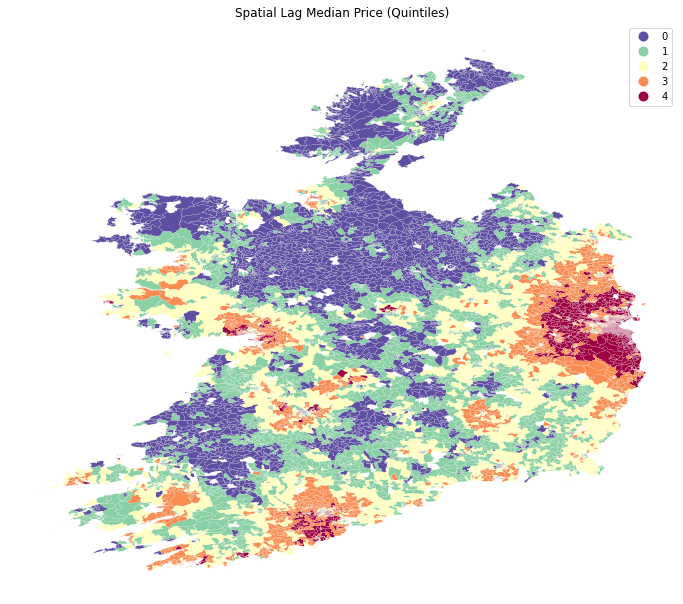

In [61]:
f, ax = plt.subplots(1, figsize=(12, 12))
edf.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='Spectral_r', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()

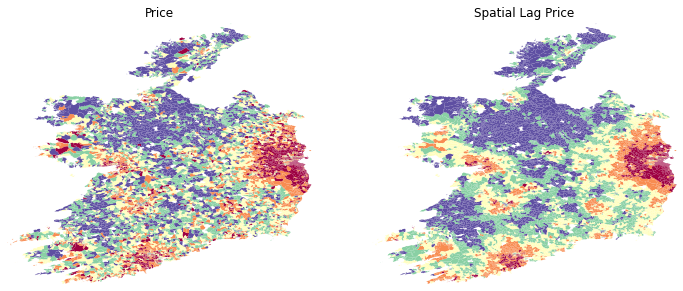

In [66]:
edf['lag_median'] = ylag
f,ax = plt.subplots(1,2,figsize=(12, 12))
edf.plot(column='mean', ax=ax[0],
        scheme="quantiles",  k=5, cmap='Spectral_r')
ax[0].axis(edf.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")


edf.plot(column='lag_median', ax=ax[1],
        scheme='quantiles', cmap='Spectral_r', k=5)
ax[1].axis(edf.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()


In [67]:
y.median()

182500.0

In [68]:
yb = y > y.median()
sum(yb)

9158

In [69]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
edf['yb'] = yb


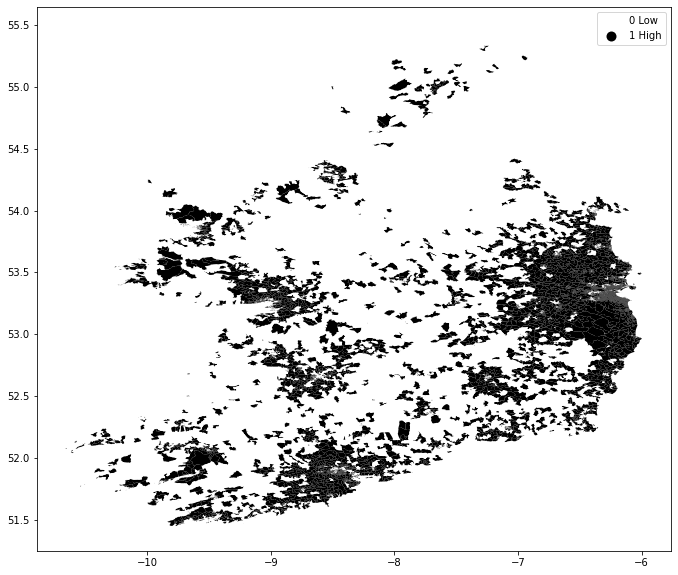

In [73]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
edf.plot(column='yb', cmap='binary', legend=True, ax=ax)

In [74]:
yb = 1 * (y > y.median()) # convert back to binary
wq =  lp.weights.Queen.from_dataframe(edf)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)


C:\Users\callm\Anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  warnings.warn(message)


Text(0.5, 0, 'BB Counts')

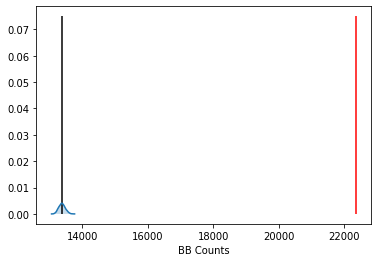

In [75]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

# Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers


In [76]:
wq.transform = 'r'
lag_price = lp.weights.lag_spatial(wq, edf['lag_median'])


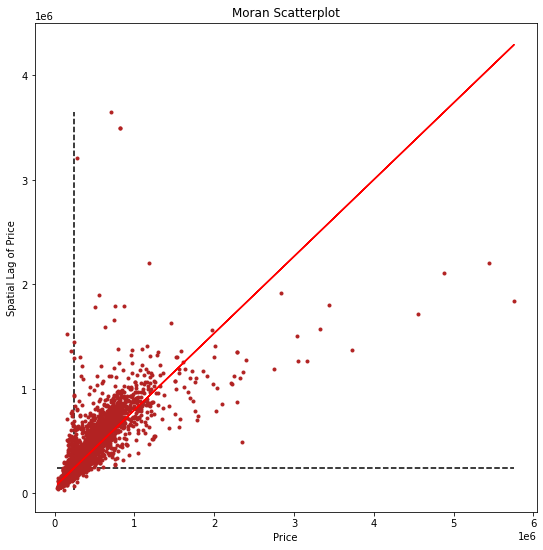

In [77]:
price = edf['lag_median']
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()


In [78]:
li = esda.moran.Moran_Local(y, wq)


In [79]:
li.q

array([3, 3, 4, ..., 1, 3, 3])

In [84]:
(li.p_sim < 0.05).sum()


6892

In [85]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [86]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

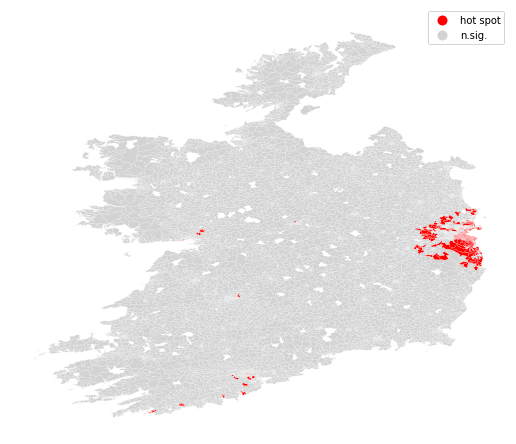

In [88]:
df = edf
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [89]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

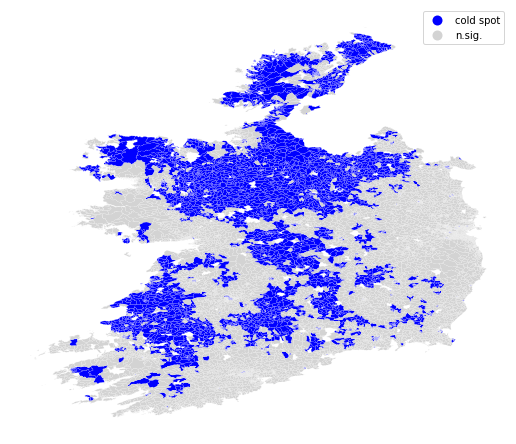

In [90]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [91]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

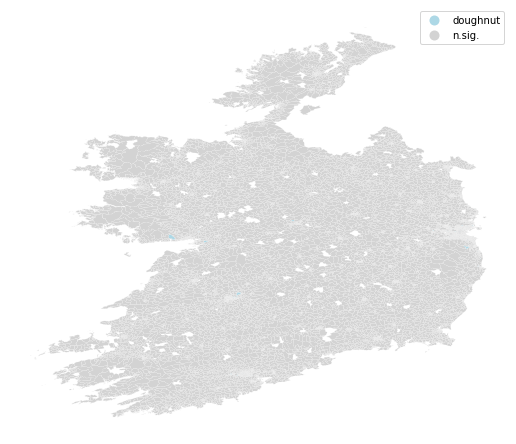

In [92]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()


In [93]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

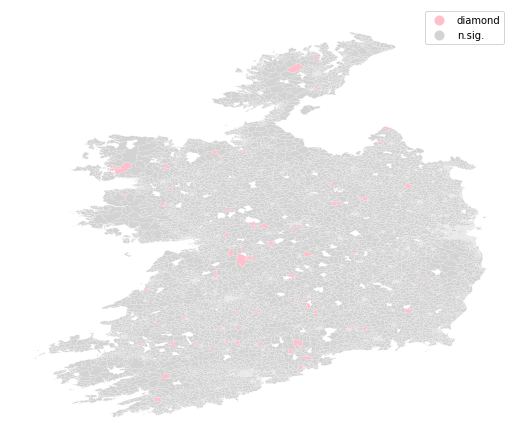

In [94]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [95]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots


array([3, 0, 0, ..., 0, 0, 0])

In [96]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

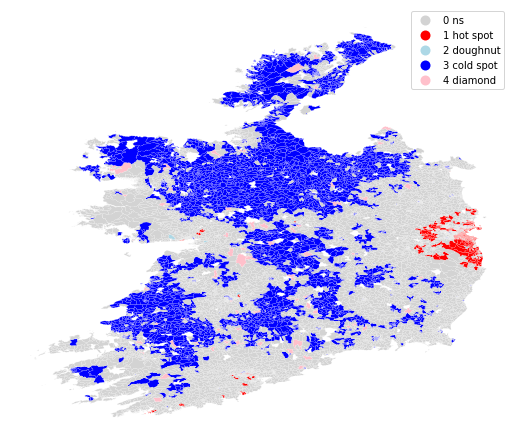

In [97]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()